# 1a) Final contamination joint analysis

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
%run toi_2266.py

In [3]:
from numba import set_num_threads

In [4]:
set_num_threads(12)

In [5]:
lpf = LPF('TOI-2266.01-joint-contaminated-a-ttv', m2_passbands=('r', 'i', 'z_s'), downsample=1)

In [57]:
sqrt(0.0004)

0.02

In [6]:
lpf.ps

[  0 |G| p              N(μ = 2.326214, σ = 0.000223)            [    0.00 ..      inf],
   1 |G| rho            U(a = 20, b = 35)                        [    0.00 ..      inf],
   2 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   3 |G| tc_0           N(μ = 2458960.2646085, σ = 0.01)         [    -inf ..      inf],
   4 |G| tc_1           N(μ = 2458962.5908225, σ = 0.01)         [    -inf ..      inf],
   5 |G| tc_2           N(μ = 2458964.9170365, σ = 0.01)         [    -inf ..      inf],
   6 |G| tc_3           N(μ = 2458967.2432505, σ = 0.01)         [    -inf ..      inf],
   7 |G| tc_4           N(μ = 2458969.5694645, σ = 0.01)         [    -inf ..      inf],
   8 |G| tc_5           N(μ = 2458974.2218925, σ = 0.01)         [    -inf ..      inf],
   9 |G| tc_6           N(μ = 2458976.5481065, σ = 0.01)         [    -inf ..      inf],
  10 |G| tc_7           N(μ = 2458978.8743205, σ = 0.01)         [    -inf ..      inf],
  11 |G| tc_8        

In [7]:
lpf.set_prior('q1_tess', 'NP', 0.78, 0.02)
lpf.set_prior('q2_tess', 'NP', 0.77, 0.02)
lpf.set_prior('q1_g', 'NP', 0.64, 0.02)
lpf.set_prior('q2_g', 'NP', 0.64, 0.02)
lpf.set_prior('q1_r', 'NP', 0.65, 0.02)
lpf.set_prior('q2_r', 'NP', 0.59, 0.02)
lpf.set_prior('q1_i', 'NP', 0.75, 0.02)
lpf.set_prior('q2_i', 'NP', 0.72, 0.02)
lpf.set_prior('q1_z_s', 'NP', 0.79, 0.02)
lpf.set_prior('q2_z_s', 'NP', 0.78, 0.02)

Global optimisation:   0%|          | 0/12500 [00:00<?, ?it/s]

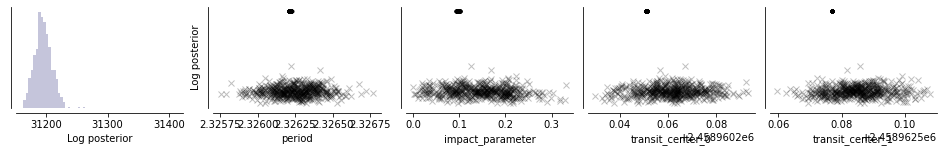

In [26]:
lpf.optimize_global(niter=12500, npop=600)

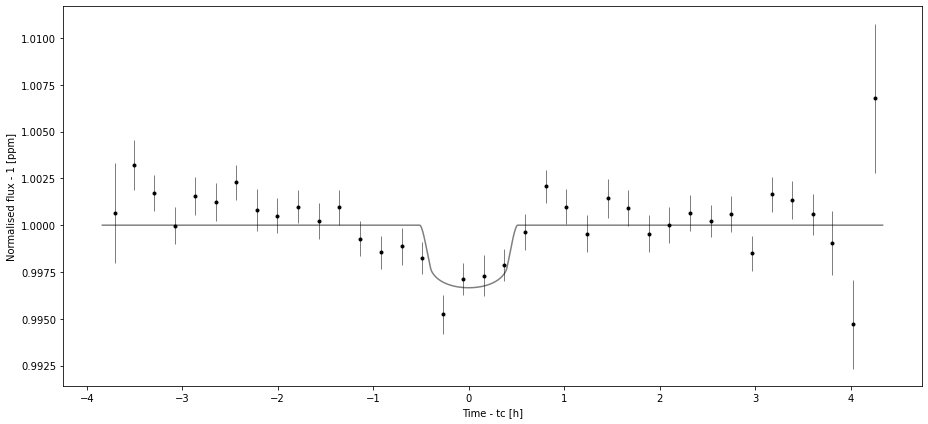

In [23]:
from pytransit.utils.downsample import downsample_time_1d
pv = lpf.de.minimum_location
#bl = lpf._lnlikelihood_models[0].predict_baseline(pv)
bl = 1.
fm = squeeze(lpf.transit_model(pv))

phase = []
oflux = []
mflux = []
for i,tc in enumerate(pv[lpf._sl_tc][:lpf._stess]):
    m = abs(lpf.timea - tc) < 0.3
    phase.append(lpf.timea[m]-tc)
    oflux.append(lpf.ofluxa[m])
    mflux.append(fm[m])
phase = concatenate(phase)
oflux = concatenate(oflux)
mflux = concatenate(mflux)

sids = argsort(phase)
bp, bf, be = downsample_time_1d(phase[sids], oflux[sids], 0.009)

fig, ax = subplots(figsize=(13, 6))
errorbar(24*bp, bf, be, fmt='.k', alpha=1, lw=0.5)
plot(24*phase[sids], mflux[sids], 'k', alpha=0.5)
setp(ax, xlabel='Time - tc [h]', ylabel='Normalised flux - 1 [ppm]')
fig.tight_layout()

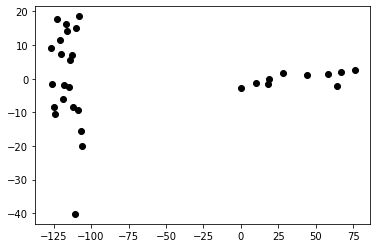

In [24]:
tcs = pv[lpf._sl_tc]
epochs = epoch(tcs, zero_epoch.n, period.n)
fitted_ephemeris = polyfit(epochs, tcs, 1)
plot(epochs,  24*60*(tcs - poly1d(fitted_ephemeris)(epochs)), 'ok')

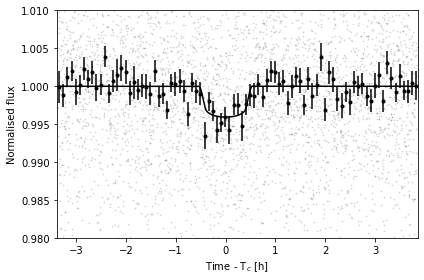

In [8]:
lpf.plot_folded_tess_transit(binwidth=5, ylim=(0.98, 1.01));

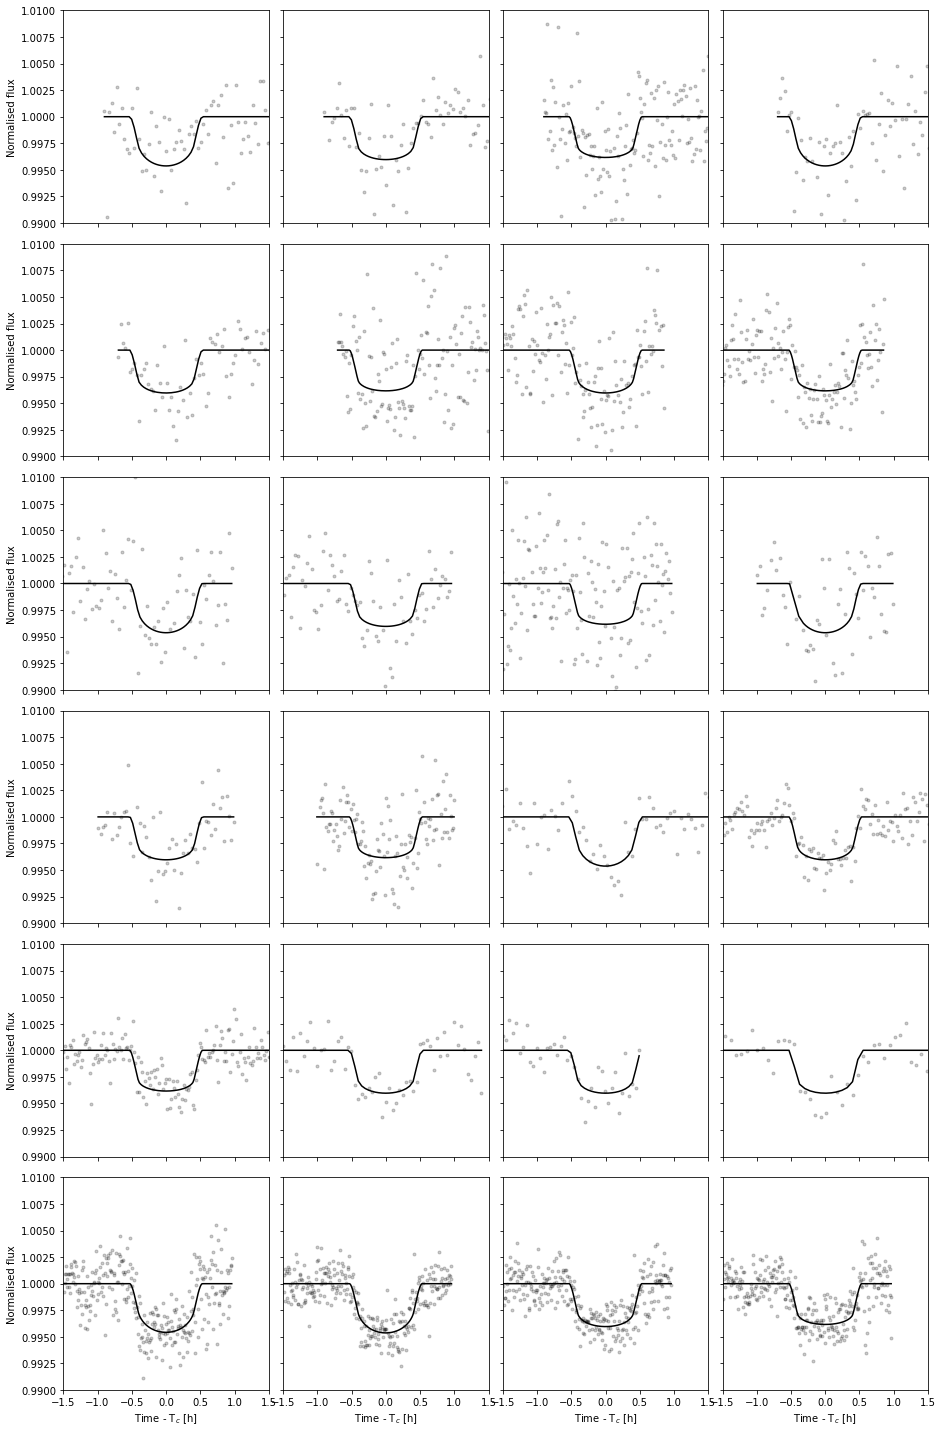

In [9]:
lpf.plot_gb_transits(figsize=(13,20), remove_baseline=True, xlim=(-1.5, 1.5), ylim=(0.99, 1.01));

In [33]:
lpf.sample_mcmc(2500, thin=250, repeats=2, save=True)

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/2500 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/2500 [00:00<?, ?it/s]

In [34]:
lpf.set_prior('rho', 'UP', 5, 35)

In [40]:
lpf.sample_mcmc(25000, thin=250, repeats=4, save=True)

MCMC sampling:   0%|          | 0/4 [00:00<?, ?it/s]

Run 1/4:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 2/4:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 3/4:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 4/4:   0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
lpf.sample_mcmc(25000, thin=250, repeats=18, save=True)

In [46]:
df = lpf.posterior_samples()

In [42]:
from corner import corner

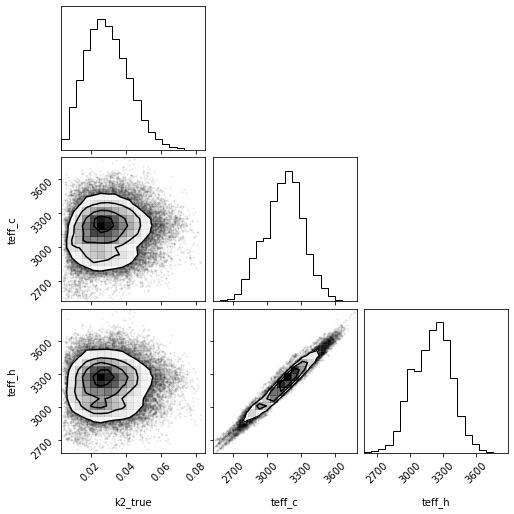

In [43]:
corner(df[['k2_true', 'teff_c', 'teff_h']]);

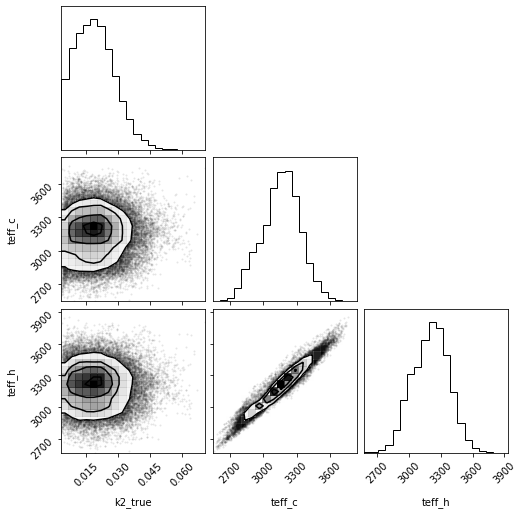

In [21]:
corner(df[['k2_true', 'teff_c', 'teff_h']]);

<AxesSubplot:>

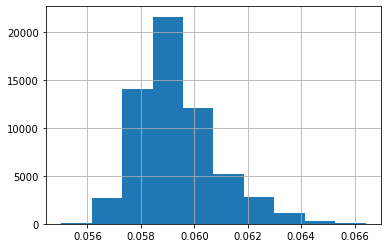

In [34]:
sqrt(df.k2_app).hist()

<AxesSubplot:>

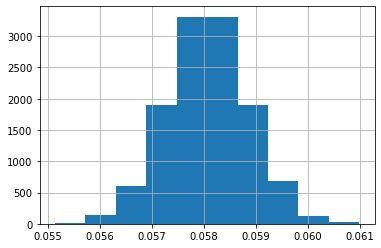

In [14]:
sqrt(df.k2_app).hist()

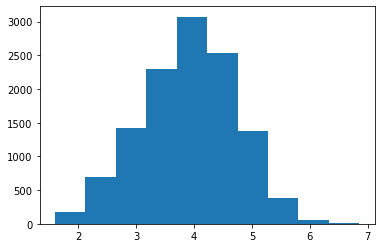

In [15]:
rs = normal(star_r.n, star_r.s, size=df.shape[0])
rp = sqrt(df.k2_true.values) * rs * (1*u.R_sun).to(u.R_earth).value
hist(rp);

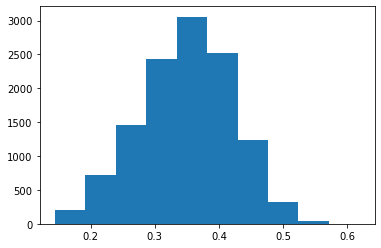

In [16]:
rs = normal(star_r.n, star_r.s, size=df.shape[0])
rp = sqrt(df.k2_true.values) * rs * (1*u.R_sun).to(u.R_jup).value
hist(rp);

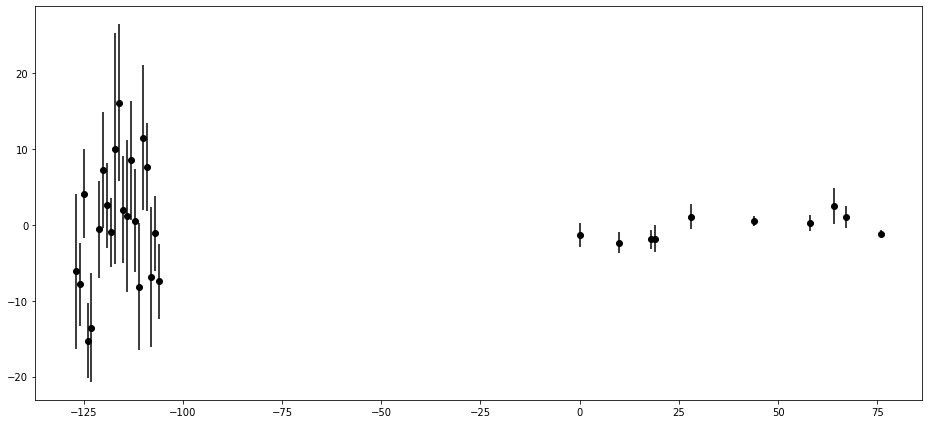

In [38]:
tcs = df.iloc[:,lpf._sl_tc].median(0)
tces = df.iloc[:,lpf._sl_tc].std(0)

epochs = epoch(tcs, zero_epoch.n, period.n)
fitted_ephemeris = polyfit(epochs, tcs, 1)
fig, ax = subplots(figsize=(13, 6))
errorbar(epochs, 24*60*(tcs - poly1d(fitted_ephemeris)(epochs)), 24*60*tces, fmt='ok')
fig.tight_layout()

In [55]:
24*60*tces

tc_0     12.604384
tc_1     10.041787
tc_2     10.355311
tc_3      8.153064
tc_4     18.354018
tc_5     10.268687
tc_6     11.449087
tc_7      7.368532
tc_8      9.446189
tc_9     14.571766
tc_10    13.054059
tc_11    11.902927
tc_12    10.172057
tc_13    10.855680
tc_14     8.526050
tc_15    10.830789
tc_16    11.446561
tc_17    12.593180
tc_18    12.383616
tc_19     9.491918
tc_20    12.679579
tc_21     1.667848
tc_22     1.637343
tc_23     1.437256
tc_24     1.775327
tc_25     1.582678
tc_26     0.664976
tc_27     1.036270
tc_28     2.489540
tc_29     1.368779
tc_30     0.440473
dtype: float64

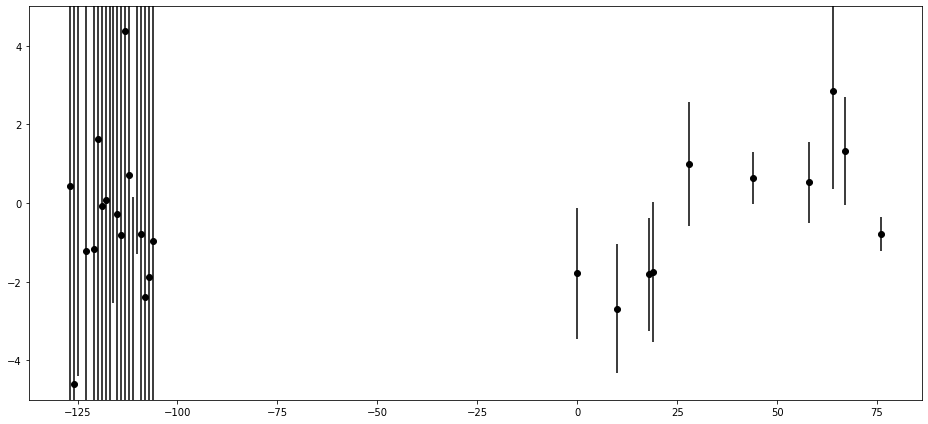

In [52]:
tcs = df.iloc[:,lpf._sl_tc].median(0)
tces = df.iloc[:,lpf._sl_tc].std(0)

epochs = epoch(tcs, zero_epoch.n, period.n)
fitted_ephemeris = polyfit(epochs, tcs, 1)
fig, ax = subplots(figsize=(13, 6))
errorbar(epochs, 24*60*(tcs - poly1d(fitted_ephemeris)(epochs)), 24*60*tces, fmt='ok')
setp(ax, ylim=(-5,5))
fig.tight_layout()


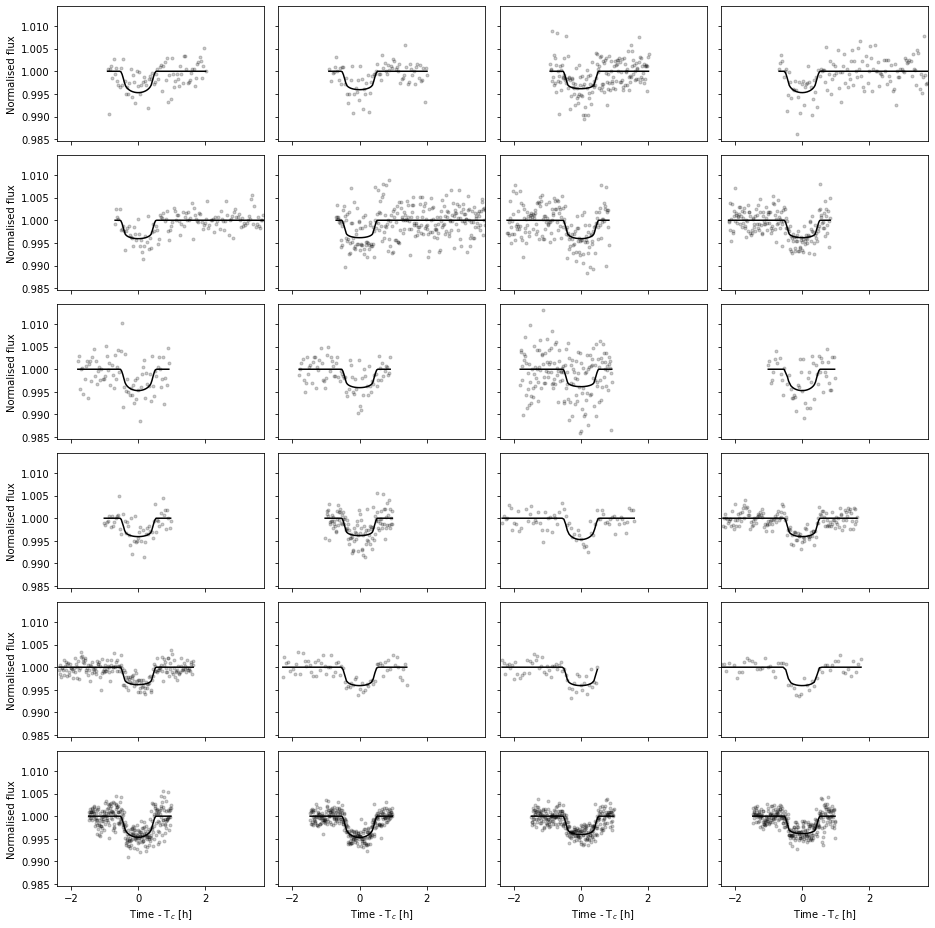

In [48]:
def plot_gb_transits(self, solution: str = 'de', pv: ndarray = None, figsize: tuple = None, axes=None, ncol: int = 4,
                         xlim: tuple = None, ylim: tuple = None, remove_baseline: bool = True, n_samples: int = 1500):

        solution = solution.lower()
        samples = None

        if pv is None:
            if solution == 'local':
                pv = self._local_minimization.x
            elif solution in ('de', 'global'):
                solution = 'global'
                pv = self.de.minimum_location
            elif solution in ('mcmc', 'mc'):
                solution = 'mcmc'
                samples = self.posterior_samples(derived_parameters=False)
                samples = permutation(samples.values)[:n_samples]
                pv = median(samples, 0)
            else:
                raise NotImplementedError("'solution' should be either 'local', 'global', or 'mcmc'")

        nlc = self.nlc - self._stess
        nrow = int(ceil(nlc / ncol))

        if axes is None:
            fig, axs = subplots(nrow, ncol, figsize=figsize, sharex='all', sharey='all', squeeze=False)
        else:
            fig, axs = None, axes

        [ax.autoscale(enable=True, axis='x', tight=True) for ax in axs.flat]

        if remove_baseline:
            if solution == 'mcmc':
                fbasel = median(self.baseline(samples), axis=0)
                fmodel, fmodm, fmodp = percentile(self.transit_model(samples), [50, 0.5, 99.5], axis=0)
            else:
                fbasel = squeeze(self.baseline(pv))
                fmodel, fmodm, fmodp = squeeze(self.transit_model(pv)), None, None
            fobs = self.ofluxa / fbasel
        else:
            if solution == 'mcmc':
                fbasel = median(self.baseline(samples), axis=0)
                fmodel, fmodm, fmodp = percentile(self.flux_model(samples), [50, 1, 99], axis=0)
            else:
                fbasel = squeeze(self.baseline(pv))
                fmodel, fmodm, fmodp = squeeze(self.flux_model(pv)), None, None
            fobs = self.ofluxa

        etess = self._stess
        p = pv[0]
        tcs = pv[self._sl_tc][self.epids[self._stess:]]

        for i in range(nlc):
            ax = axs.flat[i]
            sl = self.lcslices[etess + i]
            t = self.times[etess + i]
            tc = tcs[i]
            tt = 24 * (t - tc)
            ax.plot(tt, fobs[sl], 'k.', alpha=0.2)
            ax.plot(tt, fmodel[sl], 'k')

            if solution == 'mcmc':
                ax.fill_between(tt, fmodm[sl], fmodp[sl], zorder=-100, alpha=0.2, fc='k')

            if not remove_baseline:
                ax.plot(tt, fbasel[sl], 'k--', alpha=0.2)

        setp(axs, xlim=xlim, ylim=ylim)
        setp(axs[-1, :], xlabel='Time - T$_c$ [h]')
        setp(axs[:, 0], ylabel='Normalised flux')

        if fig is not None:
            fig.tight_layout()
        return fig

plot_gb_transits(lpf, figsize=(13,13));